<a href="https://colab.research.google.com/github/Abhi-gola/Fruit-classifier/blob/main/Facial_keypoint_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"abhigola","key":"ca6fc2f8cf690e8b1900886e54b83af9"}'}

In [2]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle competitions download -c facial-keypoints-detection

  0% 0.00/843k [00:00<?, ?B/s]
100% 843k/843k [00:00<00:00, 55.7MB/s]
  0% 0.00/201k [00:00<?, ?B/s]
100% 201k/201k [00:00<00:00, 66.7MB/s]
 31% 5.00M/16.0M [00:00<00:00, 21.7MB/s]
100% 16.0M/16.0M [00:00<00:00, 53.2MB/s]
 88% 53.0M/60.1M [00:00<00:00, 148MB/s]
100% 60.1M/60.1M [00:00<00:00, 136MB/s]


In [4]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from keras.models import Sequential, Model, load_model
from keras.layers import ReLU, Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dropout, Dense
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

In [5]:
train_data = pd.read_csv('/content/training.zip')
test_data = pd.read_csv('/content/test.zip')
idlookup_data = pd.read_csv('/content/IdLookupTable.csv')

In [6]:
test_data.head()

,ImageId,Image
0,1,182 183 182 182 180 180 176 169 156 137 124 10...
1,2,76 87 81 72 65 59 64 76 69 42 31 38 49 58 58 4...
2,3,177 176 174 170 169 169 168 166 166 166 161 14...
3,4,176 174 174 175 174 174 176 176 175 171 165 15...
4,5,50 47 44 101 144 149 120 58 48 42 35 35 37 39 ...


In [7]:
train_data.head(1)

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,right_eye_outer_corner_x,right_eye_outer_corner_y,left_eyebrow_inner_end_x,left_eyebrow_inner_end_y,left_eyebrow_outer_end_x,left_eyebrow_outer_end_y,right_eyebrow_inner_end_x,right_eyebrow_inner_end_y,right_eyebrow_outer_end_x,right_eyebrow_outer_end_y,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,23.452872,37.389402,56.953263,29.033648,80.227128,32.228138,40.227609,29.002322,16.356379,29.647471,44.420571,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,238 236 237 238 240 240 239 241 241 243 240 23...


In [8]:
idlookup_data.head()

,RowId,ImageId,FeatureName,Location
0,1,1,left_eye_center_x,NaN
1,2,1,left_eye_center_y,NaN
2,3,1,right_eye_center_x,NaN
3,4,1,right_eye_center_y,NaN
4,5,1,left_eye_inner_corner_x,NaN


In [9]:
train_data.isnull().sum()

left_eye_center_x              10
left_eye_center_y              10
right_eye_center_x             13
right_eye_center_y             13
left_eye_inner_corner_x      4778
left_eye_inner_corner_y      4778
left_eye_outer_corner_x      4782
left_eye_outer_corner_y      4782
right_eye_inner_corner_x     4781
right_eye_inner_corner_y     4781
right_eye_outer_corner_x     4781
right_eye_outer_corner_y     4781
left_eyebrow_inner_end_x     4779
left_eyebrow_inner_end_y     4779
left_eyebrow_outer_end_x     4824
left_eyebrow_outer_end_y     4824
right_eyebrow_inner_end_x    4779
right_eyebrow_inner_end_y    4779
right_eyebrow_outer_end_x    4813
right_eyebrow_outer_end_y    4813
nose_tip_x                      0
nose_tip_y                      0
mouth_left_corner_x          4780
mouth_left_corner_y          4780
mouth_right_corner_x         4779
mouth_right_corner_y         4779
mouth_center_top_lip_x       4774
mouth_center_top_lip_y       4774
mouth_center_bottom_lip_x      33
mouth_center_b

In [10]:
clean_data = train_data.dropna()
print('shape of clean data: ', clean_data.shape)
unclean_data = train_data.fillna(method = 'ffill')
print('shape of unclean data: ', unclean_data.shape)

shape of clean data:  (2140, 31)
shape of unclean data:  (7049, 31)


In [11]:
horizontal_flip = True 
brightness_augmentation = True
random_noise_augmentation = True
blurred_augmentation = True

include_unclean_data = True
sample_image_index = 20

rotation_angles = [12]
pixel_shifts = [12]

NUM_EPOCHS = 70
BATCH_SIZE = 64

In [12]:
def plot_image(image, keypoint, axis):
  image = image.reshape(96,96) #if in case image is not in this shape
  axis.imshow(image, cmap='gray')
  axis.scatter(keypoint[0::2], keypoint[1::2], marker='o', s=15)

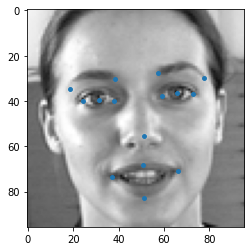

In [13]:
def load_images(image_data):
  images = []
  for index, series in image_data.iterrows():
    image = np.array(series['Image'].split(' '), dtype=int)
    image = np.reshape(image, (96,96,1))
    images.append(image)
  images = np.array(images)/255.0
  return images

def load_keypoints(keypoint_data):
  keypoint_data = keypoint_data.drop('Image', axis=1)
  keypoint_features = []
  for index, series_keypoints in keypoint_data.iterrows():
    keypoint_features.append(series_keypoints)
  keypoint_features = np.array(keypoint_features, dtype='float')
  return keypoint_features

clean_train_images = load_images(clean_data)
clean_train_keypoints = load_keypoints(clean_data)
test_images = load_images(test_data)

train_images = clean_train_images
train_keypoints = clean_train_keypoints 
fig, axis = plt.subplots()
plot_image(train_images[sample_image_index], train_keypoints[sample_image_index], axis)

if include_unclean_data:
  unclean_train_images = load_images(unclean_data)
  unclean_train_keypoints = load_keypoints(unclean_data)
  # combining with train_keypoints and train_images
  train_images = np.concatenate((train_images, unclean_train_images))
  train_keypoints = np.concatenate((train_keypoints, unclean_train_keypoints))

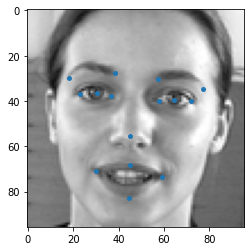

In [15]:
def horizontalflip(images, keypoints):
  flipped_keypoints = []
  flipped_images = np.flip(images, axis=2)
  for index, series in enumerate(keypoints):
    flipped_keypoints.append([96.0-coor if index%2==0 else coor for index, coor in enumerate(series)])
  return flipped_images, flipped_keypoints
if horizontal_flip:
  flipped_train_images, flipped_train_keypoints = horizontalflip(clean_train_images, clean_train_keypoints)
  train_images = np.concatenate((train_images, flipped_train_images))
  train_keypoints = np.concatenate((train_keypoints, flipped_train_keypoints))
  fig, axis = plt.subplots()
  plot_image(flipped_train_images[sample_image_index], flipped_train_keypoints[sample_image_index], axis)

Increased brightness Image 
Decreased brightness Image


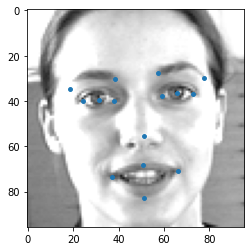

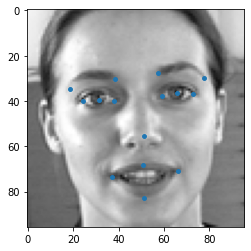

In [16]:

def change_brightness(images, keypoints):
  new_brightness_images = []
  inc_brightness_images = np.clip(images*1.3, 0.0, 1.0)
  dec_brightness_images = np.clip(images*0.7, 0.0, 1.0)
  new_brightness_images.extend(inc_brightness_images)
  new_brightness_images.extend(dec_brightness_images)
  return new_brightness_images, np.concatenate((keypoints, keypoints))

if brightness_augmentation:
  new_brightness_train_images, new_brightness_train_keypoints = change_brightness(clean_train_images, clean_train_keypoints)
  train_images = np.concatenate((train_images, new_brightness_train_images))
  train_keypoints = np.concatenate((train_keypoints, new_brightness_train_keypoints))
  fig, axis = plt.subplots()

  print("Increased brightness Image ")
  plot_image(new_brightness_train_images[sample_image_index], new_brightness_train_keypoints[sample_image_index], axis)

  fig, axis = plt.subplots()
  print("Decreased brightness Image")
  plot_image(new_brightness_train_images[len(new_brightness_train_images)//2+sample_image_index], new_brightness_train_keypoints[len(new_brightness_train_images)//2+sample_image_index], axis)

In [17]:
clean_train_images.shape[0]

2140

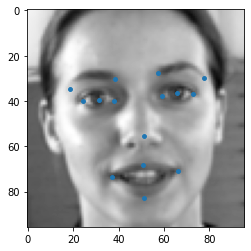

In [18]:
from scipy.ndimage.filters import gaussian_filter
def blurr_images(images, keypoints):
  blurred_images = []
  for i in range(clean_train_images.shape[0]):
    blurred = gaussian_filter(clean_train_images[20], sigma=0.6)
    blurred_images.append(blurred)
  return blurred_images, keypoints

if blurred_augmentation:
  blurred_train_images, blurred_train_keypoints =blurr_images(clean_train_images, clean_train_keypoints)
  
  train_images = np.concatenate((train_images, blurred_train_images))
  train_keypoints = np.concatenate((train_keypoints, blurred_train_keypoints))
  fig, axis = plt.subplots()
  plot_image(blurred_train_images[sample_image_index], blurred_train_keypoints[sample_image_index], axis)

In [19]:
train_images.shape

(17749, 96, 96, 1)

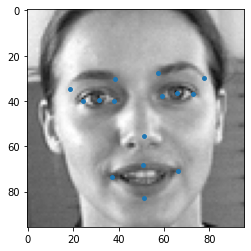

In [20]:
def add_noise(images):
  noisy_images = []
  for image in images:
    noisy_image = cv2.add(image, 0.008*np.random.randn(96,96,1))
    noisy_images.append(noisy_image.reshape(96,96,1))
  return noisy_images

if random_noise_augmentation:
  noisy_train_images = add_noise(clean_train_images)
  train_images = np.concatenate((train_images, noisy_train_images))
  train_keypoints = np.concatenate((train_keypoints, clean_train_keypoints))
  fig, axis = plt.subplots()
  plot_image(noisy_train_images[sample_image_index], clean_train_keypoints[sample_image_index], axis)

In [21]:
train_images.shape

(19889, 96, 96, 1)

In [22]:
model = Sequential()

model.add(Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(96,96,1)))
model.add(BatchNormalization())

model.add(Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(96,96,1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))

model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())

model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))

model.add(Conv2D(96, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())

model.add(Conv2D(96, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))

model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())

model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))

model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())

model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))

model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())

model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(30))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 96, 96, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 96, 96, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 32)       0         
 )                                                               
                                                        

In [35]:
checkpointer = ModelCheckpoint(filepath = 'best_model.hdf5', monitor='val_mse', verbose=1, save_best_only=True, mode='min')

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse', 'acc'])

# Train the model
history = model.fit(train_images, train_keypoints, epochs=70, batch_size=BATCH_SIZE, validation_split=0.05, callbacks=[checkpointer])

Epoch 1/70
296/296 [==============================] - ETA: 0s - loss: 22.4196 - mse: 22.4196 - acc: 0.6750
Epoch 00001: val_mse improved from inf to 23.49681, saving model to best_model.hdf5
296/296 [==============================] - 43s 138ms/step - loss: 22.4196 - mse: 22.4196 - acc: 0.6750 - val_loss: 23.4968 - val_mse: 23.4968 - val_acc: 0.5588
Epoch 2/70
296/296 [==============================] - ETA: 0s - loss: 19.2508 - mse: 19.2508 - acc: 0.6860
Epoch 00002: val_mse improved from 23.49681 to 12.17761, saving model to best_model.hdf5
296/296 [==============================] - 41s 137ms/step - loss: 19.2508 - mse: 19.2508 - acc: 0.6860 - val_loss: 12.1776 - val_mse: 12.1776 - val_acc: 0.5759
Epoch 3/70
296/296 [==============================] - ETA: 0s - loss: 16.8329 - mse: 16.8329 - acc: 0.6933
Epoch 00003: val_mse did not improve from 12.17761
296/296 [==============================] - 40s 136ms/step - loss: 16.8329 - mse: 16.8329 - acc: 0.6933 - val_loss: 21.4358 - val_mse: 2

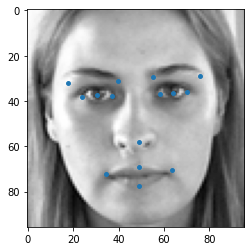

In [37]:
model = load_model('best_model.hdf5')
test_preds = model.predict(test_images)
fig, axis = plt.subplots()
plot_image(test_images[sample_image_index], test_preds[sample_image_index], axis)